<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/InventoryDemandPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  This notebook builds a catboost model for  the daily demand prediction of perishable food items. The data come from a famous turkish retailer and contains daily sales of different perisable goods between 01-10-2021 and 28-01-2023 in different stores of the retailer.


In [1]:
pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 16.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
  
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import glob
import os


In [ ]:
path = r'/content/drive/My Drive/tumexceller/'   
all_files = glob.glob(os.path.join(path, "*.xlsx"))    



df_from_each_file = (pd.read_excel(f,'Data') for f in all_files)
df_from_each_file
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)


In [ ]:
# concatenated_df.to_pickle("/content/drive/My Drive/tumexceller/concatenated_Data.pkl")


In [4]:
unpickled_df = pd.read_pickle("/content/drive/My Drive/tumexceller/concatenated_Data.pkl")  

In [6]:
retailData=unpickled_df.copy()

EXPLORATORY DATA ANALYSIS AND DATA CLEANING

In [ ]:
retailData.head()

,GÜN,HAFTA,AY,YIL,TARİH,AMBAR_NO,AMBAR,MALZEME_KODU,MALZEME_ADI,Satış Adedi,segment,İ/Ş,İL,ROUT,SEGMENT
0,5,1,1,2021,2021-01-01,100.0,Beşiktaş (İstanbul),MRK.00826,Milagro Patates File - 2 kg,16,NaN,NaN,NaN,NaN,NaN
1,5,1,1,2021,2021-01-01,100.0,Beşiktaş (İstanbul),MRK.00827,Milagro Salkım Domates - 900 g,8,NaN,NaN,NaN,NaN,NaN
2,5,1,1,2021,2021-01-01,100.0,Beşiktaş (İstanbul),MRK.00830,Milagro Şeker Domates - 250 g,13,NaN,NaN,NaN,NaN,NaN
3,5,1,1,2021,2021-01-01,100.0,Beşiktaş (İstanbul),MRK.00834,Kivi 3'lü Paket - 250 g,5,NaN,NaN,NaN,NaN,NaN
4,5,1,1,2021,2021-01-01,100.0,Beşiktaş (İstanbul),MRK.00926,Milagro Muz - 600 g,5,NaN,NaN,NaN,NaN,NaN


The last 4 columns are useless so I delete them all.

In [7]:
retailData.drop(retailData.iloc[:, 10:16], inplace=True, axis=1)


In [ ]:
# the number of samples in the data set
retailData.shape 

(11882206, 10)

In [ ]:
# the number of Null values
retailData.isna().sum().sum() ,

(10502,)

let's see which columns have NA  values and the type of each column

In [ ]:
retailData.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11876955 entries, 0 to 11882205
Data columns (total 10 columns):
 #   Column        Non-Null Count     Dtype         
---  ------        --------------     -----         
 0   GÜN           11876955 non-null  int64         
 1   HAFTA         11876955 non-null  int64         
 2   AY            11876955 non-null  int64         
 3   YIL           11876955 non-null  int64         
 4   TARİH         11876955 non-null  datetime64[ns]
 5   AMBAR_NO      11876955 non-null  float64       
 6   AMBAR         11876955 non-null  object        
 7   MALZEME_KODU  11876955 non-null  object        
 8   MALZEME_ADI   11876955 non-null  object        
 9   Satış Adedi   11876955 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 996.8+ MB


** There are 10502 NA values and according to the above table, half of the NA values come from item code and the other half comes out of store code. The rest of the columns all have non-null values. So I impute those rows with null values since rows without item and/or store code can not be feed into a machine model **

In [8]:
retailData = retailData.dropna()

In [ ]:
# the number of target values that are equal to 0
(retailData['Satış Adedi'] == 0).sum().sum()

7378135

over 75 % of the dataset have 0 sales. We dont have the stock data. However, I learned from inventory demand planners that 0 number sales are the items that the planners decided not to send these stores. that is why their sales value is equal to zero. So imputing those rows is a good idea. 

In [9]:
retailDataNzero = retailData[retailData['Satış Adedi'] != 0].reset_index(drop=True)
retailDataNzero.shape



(4498820, 10)

**Summary statistics of the new non-zero dataset**

In [ ]:
retailDataNzero.describe().round(2)

,GÜN,HAFTA,AY,YIL,AMBAR_NO,Satış Adedi
count,4504061.00,4504061.00,4504061.00,4504061.00,4498820.00,4504061.00
mean,3.04,27.58,6.59,2021.60,331.96,3.36
std,2.03,15.59,3.59,0.61,159.35,3.23
min,0.00,1.00,1.00,2021.00,100.00,-3.00
25%,1.00,13.00,3.00,2021.00,202.00,1.00
50%,3.00,28.00,7.00,2022.00,312.00,2.00
75%,5.00,41.00,10.00,2022.00,438.00,4.00
max,6.00,53.00,12.00,2023.00,818.00,92.00


Negative values are definetely errors in data preparation process. So I delete them all

In [10]:
retailDataNzero = retailDataNzero[retailDataNzero['Satış Adedi']>0].reset_index(drop=True)

In [11]:
retailDataNzero.describe().round(2)

,GÜN,HAFTA,AY,YIL,AMBAR_NO,Satış Adedi
count,4498683.00,4498683.00,4498683.00,4498683.00,4498683.00,4498683.00
mean,3.04,27.60,6.59,2021.60,331.96,3.36
std,2.03,15.59,3.59,0.61,159.35,3.22
min,0.00,1.00,1.00,2021.00,100.00,1.00
25%,1.00,13.00,3.00,2021.00,202.00,1.00
50%,3.00,28.00,7.00,2022.00,312.00,2.00
75%,5.00,41.00,10.00,2022.00,438.00,4.00
max,6.00,53.00,12.00,2023.00,818.00,92.00


except sales column, all the columns are categorical. Sales column shows that there are outlier columns  as max value is 92 while std=3.2 and the mean is 3.2.  So the target column is right skewed. Before outlier detection lets delete the negative values as they are definetely mis-valued.

OUTLIER DETECTION

below is whisker's plot for sale information. Sale column is the only column with non-categorical integer value.

<Axes: >

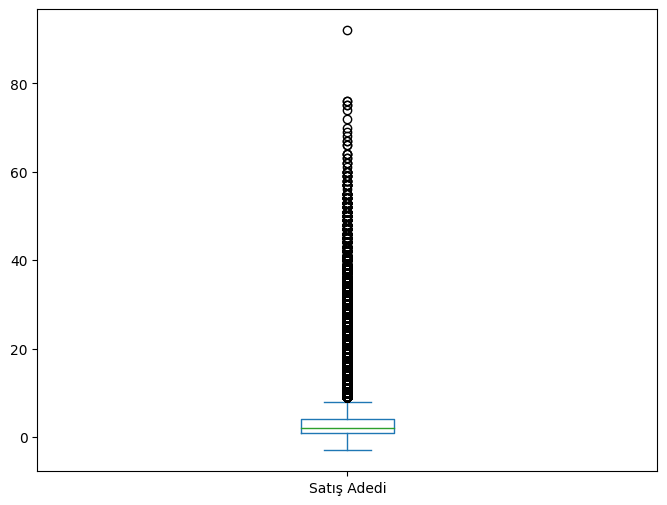

In [ ]:
retailDataNzero['Satış Adedi'].plot(kind="box", figsize=(8,6))


values above 15 are outliers yet I decide not to impute them because the inventory planners told me that that it shows the variance in the target column rather than a enrror in the dataset. That's why a model choice that is rebust to outliers is needed. 

***plotting the total sales data for every month to detect seasonality ***

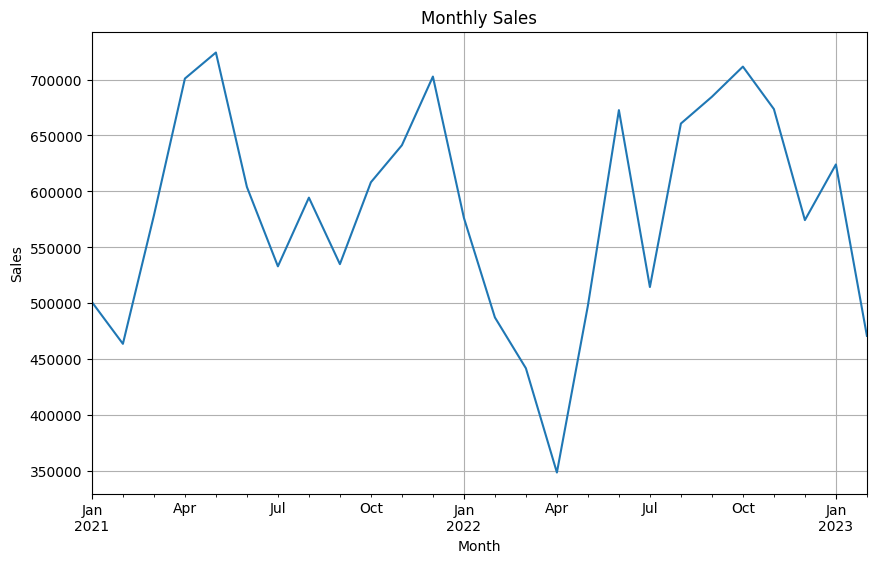

In [ ]:
monthly_sales = retailDataNzero.groupby(pd.Grouper(key='TARİH', freq='M'))['Satış Adedi'].sum()

fig, ax = plt.subplots(figsize=(10, 6))
monthly_sales.plot(kind='line', ax=ax)

plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid()
plt.show()


there seems to be a seasonal trend in the sales. 

# **`FEATURE ENGINEERING `**

as holiday period affects the sale values, I  firstly decided to add a new feature for holidays of Turkey. Then I deleted it to decrease the complexity of the model to avoid overfitting.  

In [ ]:
# def is_holiday(x):
    
#   turkey_holidays = holidays.country_holidays('TR')
  
#   if turkey_holidays.get(x):
#       return 1
#   else:
#       return 0
      
# retailDataNzero['holidays'] = retailDataNzero['TARİH'].apply(is_holiday)


In [12]:
# adding the day value of the month. Remember that the 'GÜN' value indicates the day of the week. 
retailDataNzero['day'] = pd.to_datetime(retailDataNzero['TARİH'], utc=True).dt.day

I also add the 7 day average sale of each item in each store because today's sales are affected by past sales as typical with time series data. Taking weekly averages is also the major technique the demand planners employ to predict future sales. 

In [ ]:
grouped = retailDataNzero.groupby(['AMBAR_NO', 'MALZEME_KODU'])

rolling_avg = grouped['Satış Adedi'].rolling(window=7, min_periods=1).mean()
# I shift one day because I dont want to include toda's sale in calculating the the last 7 days average.
shifted_rolling_avg = rolling_avg.groupby(level=[0,1]).apply(lambda x: x.shift(1))

retailDataNzero['last_7day_avg_sale'] = shifted_rolling_avg.values


# **MODEL TRAINING**

      After carefull review of the relevant computer science literature,  I
    decided to build a gradient boosting model. 

      There are two traditional models for demand forecasting. 
    The first is  time series analysis, the second is linear regression. 
    After the literature review, I dediced to employ machine learning models 
    since they provide better results than traditional model. RNN/lstm and 
    gradient boosting trees are the consensus in the literature among the 
    plethora of different machine learning models. I decided to train 
    gradiend boosting tree model for two reasons. 1) They are better at
    handling large amounts of data in less time and 2) they are more suitable
    for sets with large features. I choose catboost over lightgbm and xgboost 
    since all but one feature in my dataset are categorical and catboost is
    well known for its ability to handle categorical features. 

In [13]:
retailDataNzero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498683 entries, 0 to 4498682
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   GÜN           int64         
 1   HAFTA         int64         
 2   AY            int64         
 3   YIL           int64         
 4   TARİH         datetime64[ns]
 5   AMBAR_NO      float64       
 6   AMBAR         object        
 7   MALZEME_KODU  object        
 8   MALZEME_ADI   object        
 9   Satış Adedi   int64         
 10  day           int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 377.5+ MB


Catboost requires string type for categorical features. That is why I convert all categorcal features' type as string.

In [ ]:
retailDataNzero['AMBAR']=retailDataNzero['AMBAR'].astype("string") 
retailDataNzero['MALZEME_KODU']= retailDataNzero['MALZEME_KODU'].astype("string") 
retailDataNzero['MALZEME_ADI']= retailDataNzero['MALZEME_ADI'].astype("string") 
retailDataNzero['AMBAR_NO'] = retailDataNzero['AMBAR_NO'].astype("string")
retailDataNzero['GÜN'] = retailDataNzero['GÜN'].astype("string")
retailDataNzero['HAFTA'] = retailDataNzero['HAFTA'].astype("string")
retailDataNzero['AY'] = retailDataNzero['AY'].astype("string")
retailDataNzero['YIL'] = retailDataNzero['YIL'].astype("string")
retailDataNzero['day'] = retailDataNzero['day'].astype("string")



In [ ]:
retailDataNzero.to_pickle("/content/drive/My Drive/tumexceller/retailDataNzero.pkl")  


In [ ]:
retailDataNzero=pd.read_pickle("/content/drive/My Drive/tumexceller/retailDataNzero.pkl")

I use train_test_split method of scikitlearn without shuffling since it is squential data. I dont create a seperate cross validation set as I will control for overfitting during the training process

In [ ]:
features = retailDataNzero.drop(['Satış Adedi', 'TARİH', 'AMBAR', 'MALZEME_ADI', 'GÜN', 'HAFTA'], axis=1)
target = retailDataNzero['Satış Adedi'].values
  
# shuffle is zero so that we dont lose squential data. 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)


In [ ]:
features.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498683 entries, 0 to 4498682
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   AY                  4498683 non-null  string 
 1   YIL                 4498683 non-null  string 
 2   AMBAR_NO            4498683 non-null  string 
 3   MALZEME_KODU        4498683 non-null  string 
 4   day                 4498683 non-null  string 
 5   last_7day_avg_sale  4457798 non-null  float64
dtypes: float64(1), string(5)
memory usage: 205.9 MB


In [ ]:
features.head()

,AY,YIL,AMBAR_NO,MALZEME_KODU,day,last_7day_avg_sale
0,1,2021,100.0,MRK.00826,1,NaN
1,1,2021,100.0,MRK.00827,1,1.000000
2,1,2021,100.0,MRK.00830,1,1.500000
3,1,2021,100.0,MRK.00834,1,1.333333
4,1,2021,100.0,MRK.00926,1,1.500000


In [ ]:


#  the parameter grid
params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
}
cv = TimeSeriesSplit(n_splits=5)

# the model and RandomizedSearchCV
model = CatBoostRegressor(loss_function='RMSE', od_type='Iter', cat_features=[0, 1, 2, 3, 4], task_type='GPU')
search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=cv, scoring='neg_root_mean_squared_error')

# Fit the model
search.fit(X_train, y_train, plot=True)


In [ ]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the RMSE scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Best CV error: {:.4f}'.format(best_cv_error))

print('RMSE score of the best estimator on the test set:', rmse)
print('Training RMSE of best model: {:.4f}'.format(best_training_error))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean absolute percentage error score of the best estimator on the test set:', mape)


Best CV error: 2.6400
RMSE score of the best estimator on the test set: 2.76683785957103
Training RMSE of best model: 1.6248
Mean absolute percentage error score of the best estimator on the test set: 72.08936289739172
